In [1]:
import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R

%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
data_path = "data/2019_06_18_16_22_24"

tcm_raw = pd.read_csv( data_path+"tcm.csv", header=0, names=["Time", "roll", "pitch", "yaw"])
vnav_raw = pd.read_csv( data_path+"vnav.csv", header=0, names=["Time", "yaw","pitch","roll","magx","magy","magz","accelx","accely","accelz","gyrox","gyroy","gyroz"])
yost_raw = pd.read_csv( data_path+"yost.csv", header=0, names=["Time", "quat 1", "quat 2", "quat 3","quat 4"])
all_raw = [tcm_raw, vnav_raw, yost_raw]

## Fixup missing time column in yostlabs for now
# yost_raw["Time"] = tcm_raw["Time"]

In [29]:
## Set time as index
for f in all_raw:
    f.set_index("Time", inplace=True)

## TODOS:

* Vectornav:
* Yost Labs:
* TCM:  Add magnetometer/compass data

* Convert to common reference frame (perhaps using quaternions)

In [30]:
## Quaternions to euler angles
def quat2euler( row ):
    r = R.from_quat([ row["quat 1"], row["quat 2"], row["quat 3"], row["quat 4"] ])
    e = r.as_euler('zyx')
    return pd.Series( {'yaw': e[0], 'pitch': e[1], 'roll': e[2]})

def euler2quat( row, order='xyz' ):
    r = R.from_euler( order, [row["roll"], row["pitch"], row["yaw"]])
    q = r.as_quat()
    return pd.Series( {'quat 1': q[0], 'quat 2': q[1], 'quat 3': q[2], 'quat 4': q[3]} )

In [31]:
# ## Convert to degrees?
# for col in ["roll", "pitch", "yaw"]:
#     tcm_raw[col] = tcm_raw[col] * 180/np.pi 

quat = tcm_raw.apply( euler2quat, axis=1 )

tcm = tcm_raw.merge( quat, left_index=True, right_index=True )
    
tcm.head(5)

,roll,pitch,yaw,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,
0.071,-0.019519,-0.057181,-4.940356,-0.010145,0.028449,-0.621592,-0.782759
0.147,-0.019613,-0.057242,-4.941354,-0.010113,0.028508,-0.621199,-0.783069
0.253,-0.019597,-0.057223,-4.942251,-0.010100,0.028500,-0.620848,-0.783347
0.357,-0.019456,-0.057114,-4.942882,-0.010113,0.028416,-0.620605,-0.783543
0.472,-0.019258,-0.056930,-4.942798,-0.010135,0.028282,-0.620643,-0.783518


In [32]:
## Convert to radians?
for col in ["roll", "pitch", "yaw"]:
    vnav_raw[col] = vnav_raw[col] * np.pi/180

quat = vnav_raw.apply( euler2quat, axis=1 )

vnav = vnav_raw.merge( quat, left_index=True, right_index=True )

vnav.head(5)

,yaw,pitch,roll,magx,magy,magz,accelx,accely,accelz,gyrox,gyroy,gyroz,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,,,,,,,,,,
0.075,-0.298120,-0.052063,-0.011589,0.0474,0.2314,0.4046,-0.542,0.085,-9.735,0.001854,-0.001146,0.000669,-0.009594,-0.024879,-0.148605,0.988537
0.152,-0.298067,-0.052063,-0.011641,0.0494,0.2278,0.4008,-0.541,0.156,-9.746,-0.000301,-0.002110,0.002550,-0.009619,-0.024876,-0.148580,0.988541
0.258,-0.298032,-0.052028,-0.011711,0.0452,0.2267,0.4058,-0.388,0.245,-9.804,-0.000662,-0.004455,0.001036,-0.009650,-0.024853,-0.148563,0.988543
0.361,-0.297928,-0.052063,-0.011676,0.0472,0.2230,0.4034,-0.489,0.242,-9.819,0.001404,-0.001896,-0.000512,-0.009634,-0.024874,-0.148511,0.988551
0.475,-0.297963,-0.052063,-0.011676,0.0452,0.2243,0.4046,-0.495,0.124,-9.748,0.000877,-0.000018,0.001819,-0.009635,-0.024874,-0.148528,0.988548


In [36]:
# yost_raw.reset_index(inplace=True)
euler = yost_raw.apply( quat2euler, axis=1 )
yost = yost_raw.merge( euler, left_index=True, right_index=True )
#---------POST PROCESSING-------------
# NEED TO INVERT WITH QUAT MULT (FLIP UPSIDE DOWN) MAY NOT NEED TO INVERT ROLL IF DONE SO
# INVERT BEFORE CONVERTING TO EULER
yost["roll"] = - (yost["roll"])
temp = yost["pitch"]
yost["pitch"] = yost["yaw"]
yost["yaw"] = yost["pitch"]
#---------POST PROCESSING-------------
yost.head(5)

,quat 1,quat 2,quat 3,quat 4,yaw,pitch,roll
Time,,,,,,,
0.176,-0.065458,0.007237,-0.997616,0.020623,-3.101033,-3.101033,-0.011843
0.283,-0.065476,0.007262,-0.997614,0.020664,-3.100953,-3.100953,-0.011885
0.402,-0.065441,0.007227,-0.997616,0.020696,-3.100884,-3.100884,-0.011812
0.498,-0.065420,0.007310,-0.997617,0.020642,-3.101003,-3.101003,-0.011987
0.598,-0.065400,0.007348,-0.997616,0.020742,-3.100807,-3.100807,-0.012052


<Figure size 432x288 with 0 Axes>

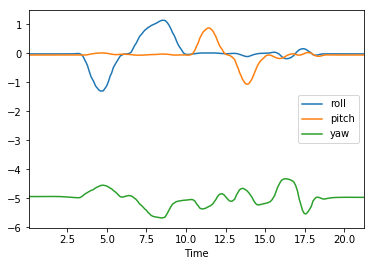

In [37]:
plt.figure()
tcm_raw.plot()

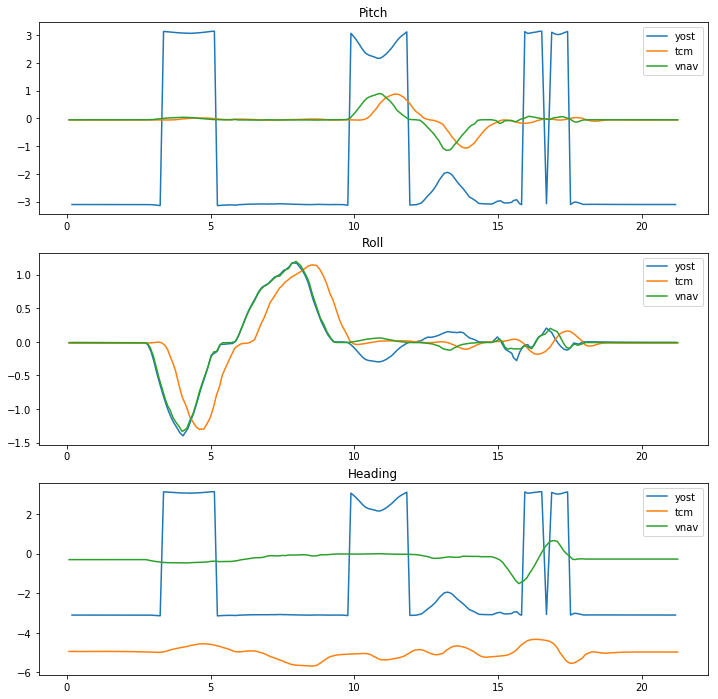

In [38]:
fig,ax = plt.subplots(3,1, figsize=(12,12))

ax[0].plot(yost['pitch'], label='yost')
ax[0].plot(tcm['pitch'], label='tcm')
ax[0].plot(vnav['pitch'], label='vnav')
ax[0].set_title('Pitch')
ax[0].legend()

ax[1].plot(yost['roll'], label='yost')
ax[1].plot(tcm['roll'], label='tcm')
ax[1].plot(vnav['roll'], label='vnav')
ax[1].set_title('Roll')
ax[1].legend()

ax[2].plot(yost['yaw'], label='yost')
ax[2].plot(tcm['yaw'], label='tcm')
ax[2].plot(vnav['yaw'], label='vnav')
ax[2].set_title('Heading')
ax[2].legend()